# Voting Classifiers

A way to improve a set of independent classifiers is to aggregate the prediction of each classsifier and predict the class the gets the most most from all the classifiers. This prediction by majority vote is called a *hard voting* classifier. This classifier made up of multiple classifiers performs better than the best classifier in the ensemble. Furthermore, a *strong learner* (a classifier that has high accuracy) can be constructed by aggregating *weak learner* (classifiers that perform slightly better than guessing) into an ensemble. This performance improvement can be achieved if there are enough weak learners and are sufficiently diverse. 

The idea behind the improvement achieved with ensembles of classifiers is the law of large numbers. For example, if there is an ensemble that has 1000 classifiers each with an accuracy of 51%, the prediction accuracy using the majority voted class should be around 75%. This happens because the more classifiers there are, the more the ratio of classification gets to 51% instead of fluctuating around 51%. This works as long as the classifiers in the ensemble are independet from each other. That is not always the case, because classifiers tend to make the same type of errors. This is why very different algorithms are used in an ensemble That way, the chance that the algorithms are making different errors is greater, so the accuracy of the ensemble is increased.

The code below creates a voting classifier

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [2]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


If all the classifiers have the method `predict_proba()` to estimate class probabilities, then it is possible to predict the highest class probability using the average from the individual classifiers. This method is called *soft voting* and most of the time performs better than *hard voting* because it gives more weight to votes with high confidence. To use soft voting instead of hard voting, it is enough to set `voting='soft` and make sure all classifiers in the ensemble are capable of estimating probabilities. 

# Bagging and Pasting

An option to get diverse classifiers, different from using different algorithms in the ensemble, is to train a single algorithm using random subsets of the trainig set. When sampling is performed with replacement it is called **bagging**, while **pasting** is when there is sampling without replacement. (For more about with and without replacement visit [Sampling With or Without Replacement](https://www.thoughtco.com/sampling-with-or-without-replacement-3126563))That is, bagging allows training instaces to be sampled several times for the same predictor. 

Once the data is sampled, the predictots are trained using the subsets and the ensemble makes a prediction aggregating the predictions of all the predictors. The aggregation function generally is the *statistical mode*, or the most frequent prediction. Since the predictor was trained using subsets of the data, it has higher bias than if the whole training set was used. However, the aggregation procedure reduces variance and bias. In general, the ensemble has a lower variance and a similar bias than a single classifier in the ensemble. 

Since the individual classifiers can be trained and make predictions in parallel, the methods of bagging and pasting scale very well.

To use bagging and pasting in Scikit-Learn, the class `BaggingClassifier` should be used. The code below trains 500 Decision Tree classifiers. The number of instances used to train each classifier are determined by the parameter `max_samples` which can be the number of samples of the ratio of samples from the total number of instances. The parameter `bootstrap` is set true by default, so bagging is the default method. If pasting is the method wanted, `bootsrap` should be set to False. Also, the `n_jobs` parameter determines how many cores should be used during training and prediction. If `n_jobs=-1`, all the available cores will be used. The `BaggingClassifier` performs soft voting by default if all the classifiers in the ensemble can estimate class probabilities.

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=0.5, bootstrap=True, n_jobs=-1
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.912


To compare the results, a single Decision Tree is trained.

In [4]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [5]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

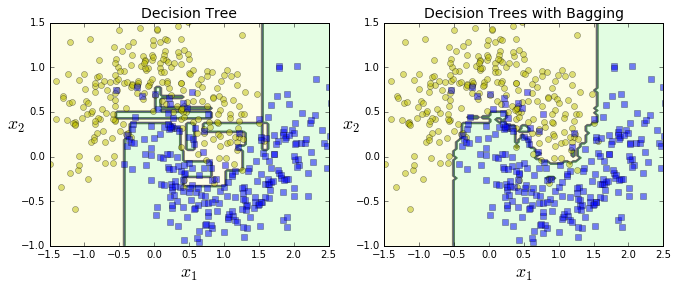

In [6]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

Is seen in the plots above, the decision boundary resulting with bagging should generalize better than the boundary obtained from a single Decision Tree. Comparing pasting and bagging, bagging ends up with a slightly higher bias than pasting. This also means that the individual classifiers end up being less correlated so the ensemble bias is reduced. 

Bagging results in better models than pasting, but, if time and CPU power are an issue, cross-validation should be used to compare bagging and pasting. 

## Out-of-Bag Evaluation

When bagging is used, some instances can by sampled multiple time for a classifier. Other instances in the datasets may not be sampled by any classifier. In fact, about 37% of the training instances are not sampled for each predictor. These training instances that are not sampled are called *out-of-bag* (oob) instances. 

Taking into account that each classifier does not use the oob instance during training, these instances can be used to evaluate the classifier. This evaluation can be set automatically by setting `oob_score=True` when creating a Bagging Classifier. 

In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.89600000000000002

In [8]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.90400000000000003

**From both values above it can be seen that the evaluation using oob instance is close to the accuracy score using a test set.** 

Also, the oob decision function for each training instance is available after training the ensemble. When the classifiers in the ensemble can output a prediction probability, the decision function returns the class probabilities for each instance.

In [9]:
bag_clf.oob_decision_function_

array([[ 0.45454545,  0.54545455],
       [ 0.40331492,  0.59668508],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.05434783,  0.94565217],
       [ 0.29064039,  0.70935961],
       [ 0.01980198,  0.98019802],
       [ 0.97905759,  0.02094241],
       [ 0.96590909,  0.03409091],
       [ 0.79329609,  0.20670391],
       [ 0.00588235,  0.99411765],
       [ 0.79      ,  0.21      ],
       [ 0.82716049,  0.17283951],
       [ 0.9726776 ,  0.0273224 ],
       [ 0.04878049,  0.95121951],
       [ 0.00510204,  0.99489796],
       [ 0.98941799,  0.01058201],
       [ 0.91176471,  0.08823529],
       [ 0.99378882,  0.00621118],
       [ 0.02994012,  0.97005988],
       [ 0.38285714,  0.61714286],
       [ 0.92397661,  0.07602339],
       [ 1.        ,  0.        ],
       [ 0.96923077,  0.03076923],
       [ 0.        ,  1.        ],
       [ 0.98888889,  0.01111111],
       [ 1.        ,  0.        ],
       [ 0.        ,

# Random Patches and Random Subspaces

The `BaggingClassifier` class in Scikit-Learn supports sampling features. Feature sampling is controlled by the parameters `max_features` and `bootstrap_features`. These two hyperparameters work the same as `max_samples` and `bootstrap` for the instance sampling. When features, instead of instances, are sampled, each predictor is trained using a subset of the features. Sampling features is useful for dealing with high-dimensional inputs. 

+ Random Patches: Sampling of training instances and features
+ Random Subspaces: Keeping all training instances but sampling features

# Random Forests

A Random Forest is an ensemble of Desicion Trees that are generally trained using bagging. Instead of the `BaggingClassifier` class, the class `RandomForestClassifier` is used for Decision Trees ensembles. The parameter `n_estimators` sets the number of trees in the forest. With only a few exceptions, the `RandomForestClassifier` has all the parameters from the `DecisionTreeClassifier` class to control how trees grow in the forest. 

The Random Forest algorithm searches for the best feature among a random subset of features when splitting a node instead of looking for the best feature from all the available features in the training set. This introduces randomness when growing the trees, so the resulting forest has greater tree diversity.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

accuracy_score(y_test, y_pred_rf)

0.92000000000000004

## Extra-Trees

To make random forests more random, it is possible to choose the threshods for each feature randomly instead of searching for the optimal threshold. This type of Random Forest is called *Extremely Randomized Trees* or Extra-Trees. This method is fastet to train than a regular Random Forest.

The class in Scikit-Learn to create Extra-Trees is `ExtraTreesClassifier`. The hyperparameters are identical to the ones of the `RandomForestClassifier`. It is hard to tell in advance which model will perform better between Extra-Trees and Random Forest. The only certain way is to train both and compare them using cross-validation.

## Feature Importance

Another useful feature of Random Forests is the fact that the realative importance of each feature is calculated during training. The importance of each feature is determined by looking how much impurity is reduced in the nodes that use each feature. The contribution of each node is a weighted average, because the weight of each node is determined by the number of training samples in each node. 

This feature importance is calculated by Scikit-Learn during training and can be accessed using the `feature_importances_` variable. 

The fact that Random Forests are capable of calculating the importance of features, makes this model useful to understand which features matter the most.

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.103423125131
sepal width (cm) 0.0238843710555
petal length (cm) 0.436535935455
petal width (cm) 0.436156568358


# Boosting

In general, boosting is any ensemble method that combines weak learners into a stronger learner. The idea behind boosting is to train predictors in a sequence so that a predictor fixes the errors of its predecessor.

## AdaBoost

One way to make the preceding model better is to pay attention to the training instances that the previous model underfitted. This method is called AdaBoost (Adaptive Boosting) and makes the predictors in the sequence focus in the hard cases. 

At the beginning of the sequence, each instance weight $w^{(i)}$ is set to $\frac{1}{m}$. Then, the first predictor is trained and the weighted error of the predictor $r_{1}$ is calculated on the training set.

The equation for calculating the error of predictor $j$ is

$r_{j} = \frac{\sum_{ \text{Errors}} w^{(i)}}{\sum_{i=1}^{m} w^{(i)}}$

In the numerator, the sum goes only over the instances in which the predicted value differs from the target value in the training set.

Then the predictor's weight $\alpha_{j}$ is calculated using the equation

$\alpha_{j} = \eta \log \frac{1-r_{j}}{r_{j}}$

where $\eta$ is the learning rate hyperparameter. This learning rate hyperparameter controls the weight given duuring training to wrong instances. It can be seen from the previous equation that the more accurate the predictor is, the higher its weight will be. If the predictor is more often wrong than right, its weight will be negative. 

Next, the instance weights have to be update using the following rules:

+ $w^{(i)}_\text{new} = w^{(i)}$ if prediction of instance i is correct
+ $w^{(i)}_\text{new} = w^{(i)}\exp(\alpha_{j})$ if prediction is incorrect

According to these rules, the weight of misclassified instances is boosted while the weights of the correctly classified instances remain unchanged.

After all the weights are updated, the weights are normalized dividing them by $\sum_{i=1}^{m}w^{(i)}$.

Then, a new predictor is trained using the new weights and the whole process is repeated until the number of desired predictors is reached or when the perfect predictor is found. 

The predictions in AdaBoost are calculated by predicting the class in each predictor of the sequence. Then, the predicted class is chosen by a majority of weighted votes from all the predictors. The vote from each predictor is weighted using $\alpha_{j}$ of each predictor. 

In Scikit-Learn, SAMME is used instead of AdaBoost. SAMME is the multiclass version of AdaBoost, so both are equivalent when there are only two classes. Furthermore, if the predictors in the ensemble can predict probabilities, a variant of SAMME called SAMME.R can be used. Using SAMME.R is beneficial because it generally performs better. 

The code below trains 200 Decision Stumps (or Decision Trees with max_depth = 1) using the `AdaBoostClassifier` class.

In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5
)

ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.89600000000000002

To fix overfitting in an AdaBoost ensemble, the number of estimator can be reduced as well as imposing a stronger regularizarion for the base estimator.